In [2]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime

from models.aae import Encoder, Decoder, Discriminator, train, reconstruction_anomaly
from tools.viz import plot_anomaly_scores, plot_train_hist
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((-1, 1))
        self.l_dim = 128
        # self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 500
        self.sample_interval = 25
        self.train_plots = True
        
        # create ouput dirs
        self.model_out = Path('./runs/aae/' + time_id + f"_ldim{self.l_dim}")
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["aae", "joint", "minmax", "test"]
        self.desc = "No model reset"
        self.type = "AAE"
        
opts = Options()


# Setup Training Dataset

In [3]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]


Unscaled inputs shape: (11066, 1280)


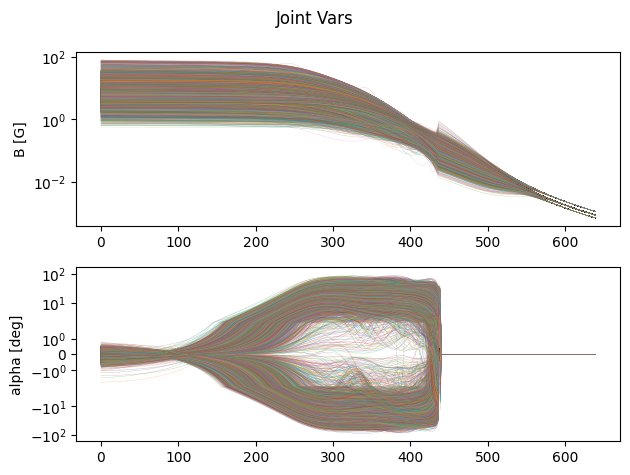

In [4]:
dataset.plot(title="Joint Vars")

# Models

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
netEnc = Encoder(
    input_size=dataset.shape[1],
    l_dim=opts.l_dim,  
    device=device 
).to(device)
netDec = Decoder(
    output_size=dataset.shape[1],
    l_dim=opts.l_dim,
).to(device)

netD = Discriminator(
    l_dim=opts.l_dim,
).to(device)

Using device:  cuda:0


In [5]:
netEnc.train()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (mu): Linear(in_features=512, out_features=128, bias=True)
  (logvar): Linear(in_features=512, out_features=128, bias=True)
)

In [6]:
netDec.train()

Decoder(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1280, bias=True)
    (5): Tanh()
  )
)

In [7]:
netD.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [8]:
netD

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
logger = Logger([netEnc, netDec, netD], opts.model_out / f"{time_id}.md", vars(opts))

# Training

In [10]:
G_losses, D_losses = train(netEnc, netDec, netD, dataloader, opts, device)

Starting Training Loop...


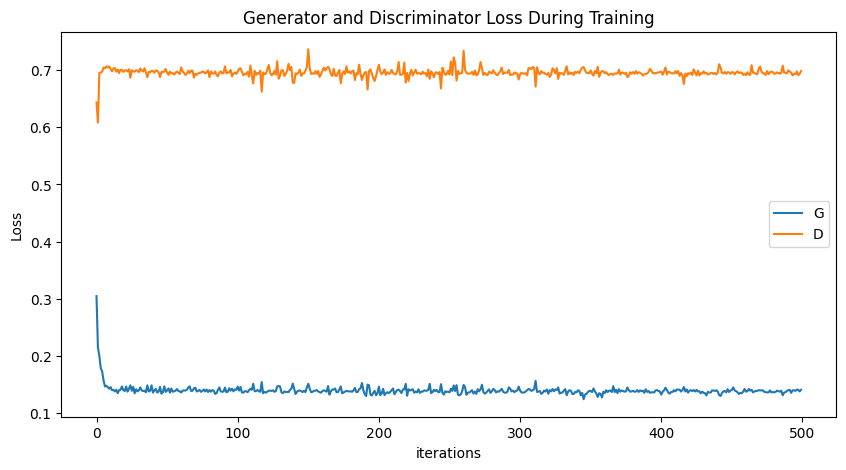

In [11]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [6]:

netEnc.train(False)
netDec.train(False)
netD.train(False)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    models_dir = Path("./runs/aae/0321-1133_ldim128")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netEnc.load_state_dict(torch.load(opts_eval.models_dir / 'Enc.pth'))
netDec.load_state_dict(torch.load(opts_eval.models_dir / 'Dec.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D.pth'))

<All keys matched successfully>

In [7]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]


## Reconstruction Error

In [8]:
scores = []
loss_fn = nn.MSELoss(reduction="none")
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    errG = loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores.append((filename, error))

Anomaly Threshold:  0.0015809348551556468
Found 1439 anomalies


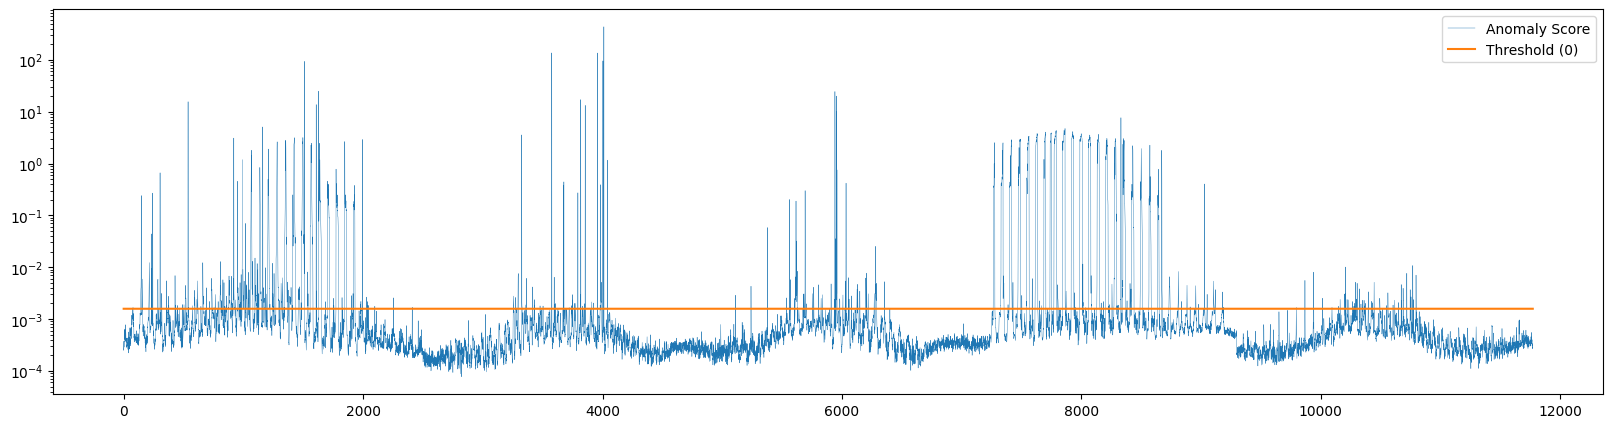

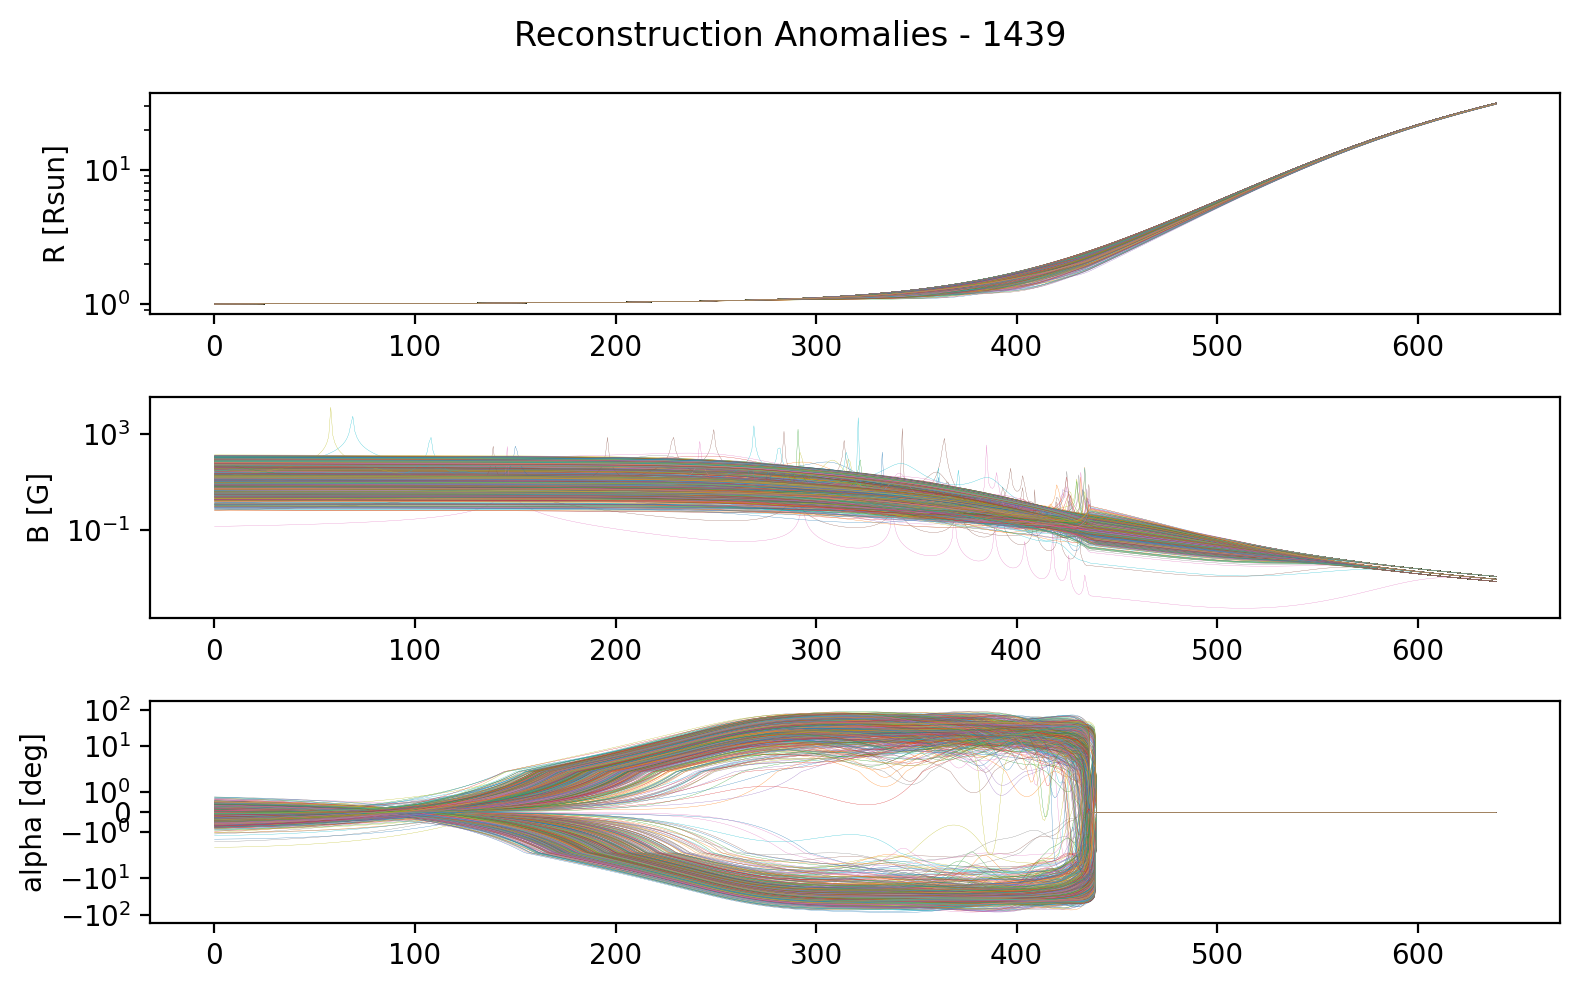

In [9]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Reconstruction")

## Reconstruction + Discriminator

In [11]:
scores_discr = []
loss_fn = nn.L1Loss(reduction="none")
criterion = nn.BCELoss()

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = 0.1 * criterion(netD(enc_x), real_labels) + 0.9 * loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        # print(sample, filename)
        scores_discr.append((filename, error))

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

Anomaly Threshold:  0.09174774
Found 1177 anomalies


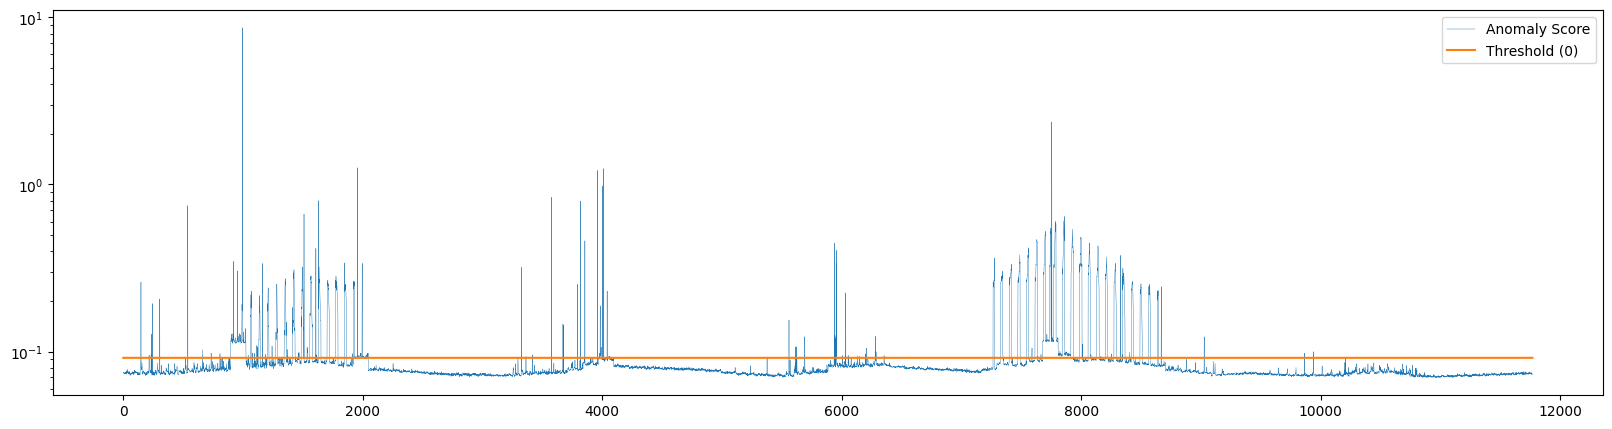

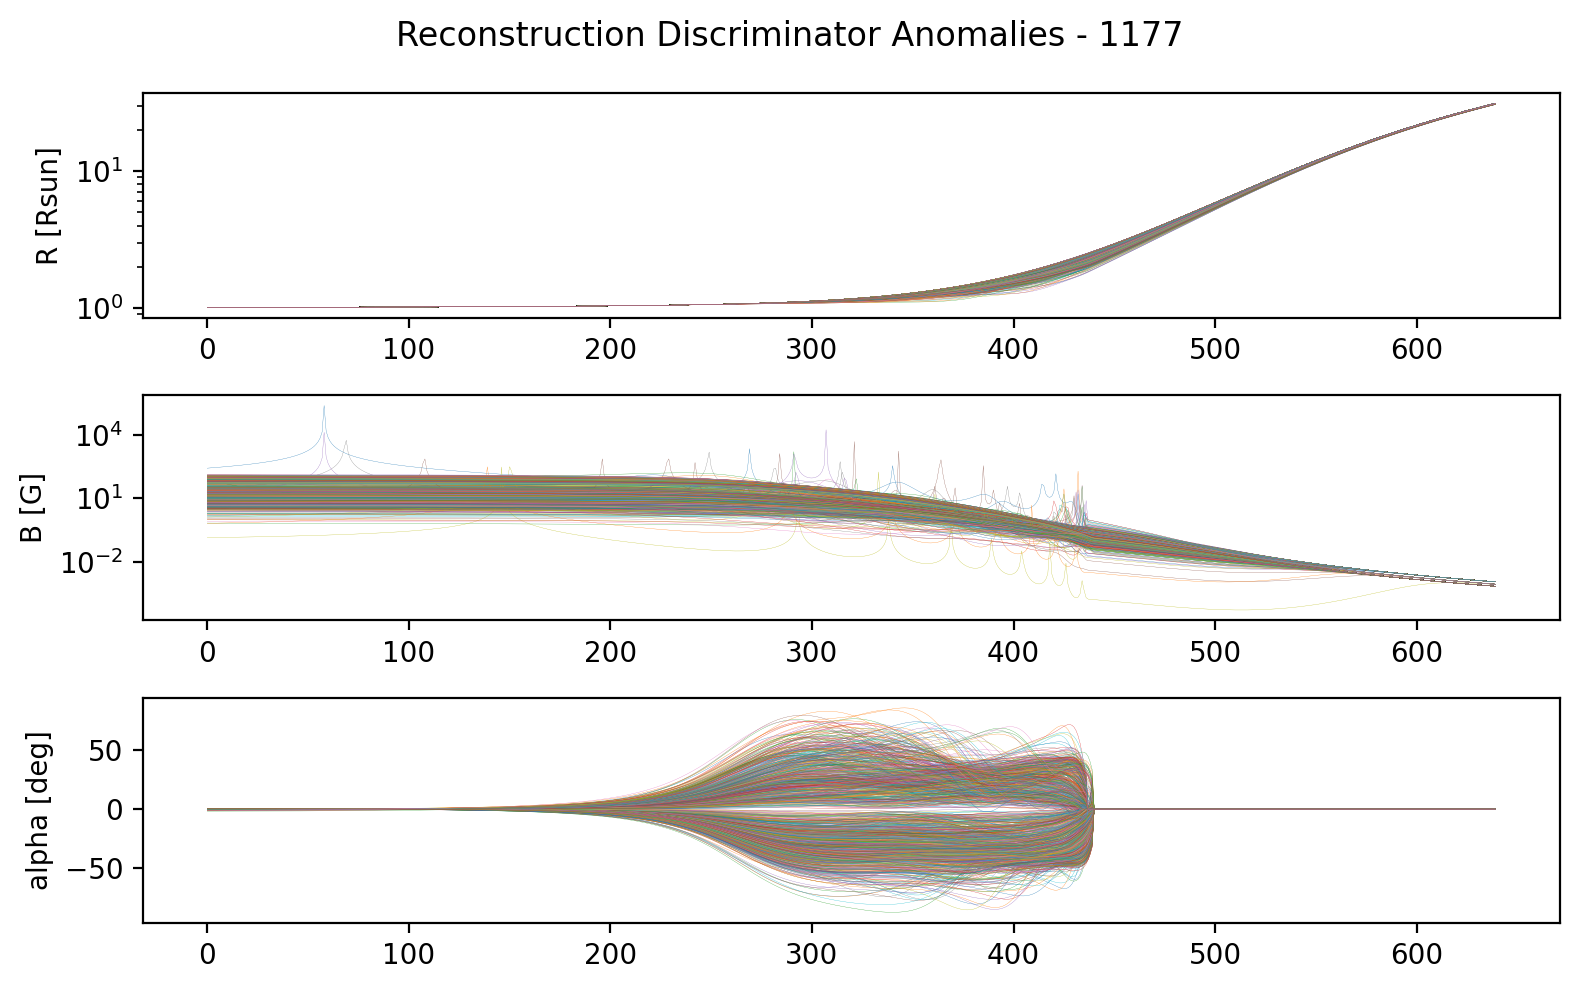

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_discr_scores", 
                        scale="log", method="Reconstruction Discriminator")